In [1466]:
library('ggplot2')
library('patchwork')
library('data.table')
library('dplyr')
library('rgeos')
library('mapproj')
library('RColorBrewer')
library('ggvoronoi')
library('rjson')
library('cowplot')
library('gridExtra')
library('grid')
library('sets')
library('sp')
library('tidyr')
library('ggnewscale')
library('scales')
load("~/locator/data/cntrymap.Rdata")

In [1418]:
pal = c('#235862','#e740b4','#ffccba','#54d705','#fcfcfc')
palgen = colorRampPalette(pal)
colgen = colorRamp(pal)
figdir = '/home/crehmann/public_html/locator-residuals/' # place to save figures to

Anopheles & Plasmodium empirical predictions

In [1596]:
# error for ALL samples -

ag <- fread('data/ag1000g_centroids.txt')
md <- fread('data/ag1000g_v3_gambiae.txt')
ag <- merge(ag, md, on='sampleID')
ag <- ag[,c('x','y','kd_x','kd_y')]
ag[] <- lapply(ag, as.numeric)
ag$organism <- 'anopheles'
ag <- ag[ag$y < 25,]

pf <- fread('data/pf7_centroids.txt')
md <- fread('data/pf7_africa_QC.txt')
pf <- merge(pf, md, on='sampleID')
pf <- pf[,c('x','y','kd_x','kd_y')]
pf[] <- lapply(pf, as.numeric)
pf$organism <- 'plasmodium'

pd <- rbind(ag, pf)
tlocs <- as.matrix(pd[,c('x','y')])
plocs <- as.matrix(pd[,c('kd_x','kd_y')])
pd$error <- sapply(1:nrow(plocs),function(e) spDistsN1(t(as.matrix(plocs[e,])),
                   t(as.matrix(tlocs[e,])),longlat = TRUE))

summary <- pd %>% group_by_at(c('x', 'y', 'organism')) %>%
                  summarize(kd_x_mean = mean(kd_x),
                  kd_y_mean = mean(kd_y),
                  error = mean(error))

`summarise()` has grouped output by 'x', 'y'. You can override using the `.groups` argument.


In [1597]:
# condense proximate Anopheles sampling locations in Cameroon

afgroup <- summary[summary$y < 10 & 
            summary$y > 4 &
            summary$x > 10 &
            summary$x < 15 &
            summary$organism == 'anopheles',]
summary <- summary[!(summary$y < 10 & 
            summary$y > 4 &
            summary$x > 10 &
            summary$x < 15 &
            summary$organism == 'anopheles'),]

mean <- colMeans(afgroup[,c('x','y','error','kd_x_mean','kd_y_mean')])

summary <- rbind(summary, data.table(x=mean['x'], y=mean['y'], error=mean['error'], kd_x_mean=mean['kd_x_mean'], kd_y_mean=mean['kd_y_mean'], organism='anopheles'))

afgroup <- summary[summary$y < 15 & 
            summary$y > 10 &
            summary$x > 10 &
            summary$x < 15 &
            summary$organism == 'anopheles',]
summary <- summary[!(summary$y < 15 & 
            summary$y > 10 &
            summary$x > 10 &
            summary$x < 15 &
            summary$organism == 'anopheles'),]

mean <- colMeans(afgroup[,c('x','y','error','kd_x_mean','kd_y_mean')])

summary <- rbind(summary, data.table(x=mean['x'], y=mean['y'], error=mean['error'], kd_x_mean=mean['kd_x_mean'], kd_y_mean=mean['kd_y_mean'], organism='anopheles'))

In [1598]:
pred_plot <- ggplot()+theme_classic()+
            # plot map
            coord_map(projection = "mollweide",
                   xlim=c(min(na.omit(c(summary$kd_x_mean,summary$x)))-2.5,
                          max(na.omit(c(summary$kd_x_mean,summary$x)))+2.5),
                   ylim=c(min(na.omit(c(summary$kd_y_mean,summary$y)))-2.5,
                          max(na.omit(c(summary$kd_y_mean,summary$y)))+2.5))+
            geom_polygon(data=fortify(map),aes(x=long,y=lat,group=group),fill="#ebebeb",color="white",lwd=0.2)+
                            theme(axis.title = element_blank())+
            geom_point(summary, mapping=aes(x=x, y=y, group=organism, color=organism)) +
            scale_color_manual(name="Location", values=c(aglight, pfdark)) +   
            new_scale_colour() +
            geom_segment(summary, mapping=aes(x=x, y=y, xend=kd_x_mean, yend=kd_y_mean, group=organism, color=organism), alpha=0.6) +
            scale_color_manual(values=c(aglight, pfdark)) +
            new_scale_colour() +
            geom_point(summary, mapping=aes(x=kd_x_mean, y=kd_y_mean, group=organism, color=organism, size=error), alpha=0.75) + 
            scale_color_manual(values=c(agdark, pflight))

Regions defined for each Polygons



In [1599]:
agemperr <- pd[pd$organism=='anopheles',]$error
agd <- ggplot(mapping = aes(pd[pd$organism=='anopheles',]$error))+theme_classic()+
        geom_density(fill=aglight, color=agdark, alpha=0.5)+
        ylab('')+xlab('Anopheles prediction error')+
        theme(axis.ticks.y = element_blank(),
        axis.text.y = element_blank()) +scale_x_continuous(trans='log10')

pfemperr <- pd[pd$organism=='plasmodium',]$error
pfd <- ggplot(mapping = aes(pd[pd$organism=='plasmodium',]$error))+theme_classic()+
        geom_density(fill=pflight, color=pfdark, alpha=0.5)+
        ylab('')+xlab('Plasmodium prediction error')+
        theme(axis.ticks.y = element_blank(),
        axis.text.y = element_blank())+
        expand_limits(x=0, y=0)+scale_x_continuous(trans='log10')

In [1600]:
mean(pd[pd$organism=='anopheles',]$error)
median(pd[pd$organism=='anopheles',]$error)
mean(pd[pd$organism=='plasmodium',]$error)
median(pd[pd$organism=='plasmodium',]$error)

[1] 130.3151

[1] 12.86798

[1] 203.0839

[1] 8.181902

In [1431]:
# residual correlations

corr = fread('data/ag_pf_correlation.txt')
corr$type = rep('Spatial pairs', nrow(corr))
perm = fread('data/ag_pf_permutation.txt')
perm$type = rep('Random pairs', nrow(perm))
corr_perm = rbind(corr, perm)
corr_perm$Mag <- corr_perm$mag

Warning message in fread("data/ag_pf_correlation.txt"):
“Stopped early on line 1002. Expected 4 fields but found 1. Consider fill=TRUE and comment.char=. First discarded non-empty line: <<=======>>”
Warning message in fread("data/ag_pf_permutation.txt"):
“Stopped early on line 1002. Expected 4 fields but found 1. Consider fill=TRUE and comment.char=. First discarded non-empty line: <<=======>>”


In [1432]:
print(c('vector correlation:', mean(corr_perm[corr_perm$type == 'Spatial pairs',]$vector)))
print(c('angle correlation:',mean(corr_perm[corr_perm$type == 'Spatial pairs',]$angle)))
print(c('magnitude correlation:',mean(corr_perm[corr_perm$type == 'Spatial pairs',]$Mag)))

[1] "vector correlation:" "0.0773819763989811" 
[1] "angle correlation:" "0.0170283555662386"
[1] "magnitude correlation:" "0.0922119815605064"    


In [1433]:
vector <- ggplot()+theme_classic()+
    geom_boxplot(corr_perm, lwd=0.1, outlier.size=0.1, mapping=aes(x=vector, fill=reorder(type, -vector)), show.legend = FALSE)+coord_flip()+
    scale_fill_manual(name="Type", values=c("Spatial pairs"=aglight, "Random pairs"=pfdark))+
    ylab('Vector correlation')+xlab('')+theme(
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank())

angle <- ggplot()+theme_classic()+
    geom_boxplot(corr_perm, lwd=0.1, outlier.size=0.1, mapping=aes(x=angle, fill=reorder(type, -vector)), show.legend = FALSE)+coord_flip()+
    scale_fill_manual(name="Type", values=c("Spatial pairs"=aglight, "Random pairs"=pfdark))+
    ylab('Angle correlation')+xlab('')+theme(
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank())

magn <- ggplot()+theme_classic()+
    geom_boxplot(corr_perm, lwd=0.1, outlier.size=0.25, mapping=aes(x=Mag, fill=reorder(type, -vector)))+coord_flip()+
    scale_fill_manual(name="Type", values=c("Spatial pairs"=aglight, "Random pairs"=pfdark))+
    ylab('Magnitude correlation')+xlab('')+theme(
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank())

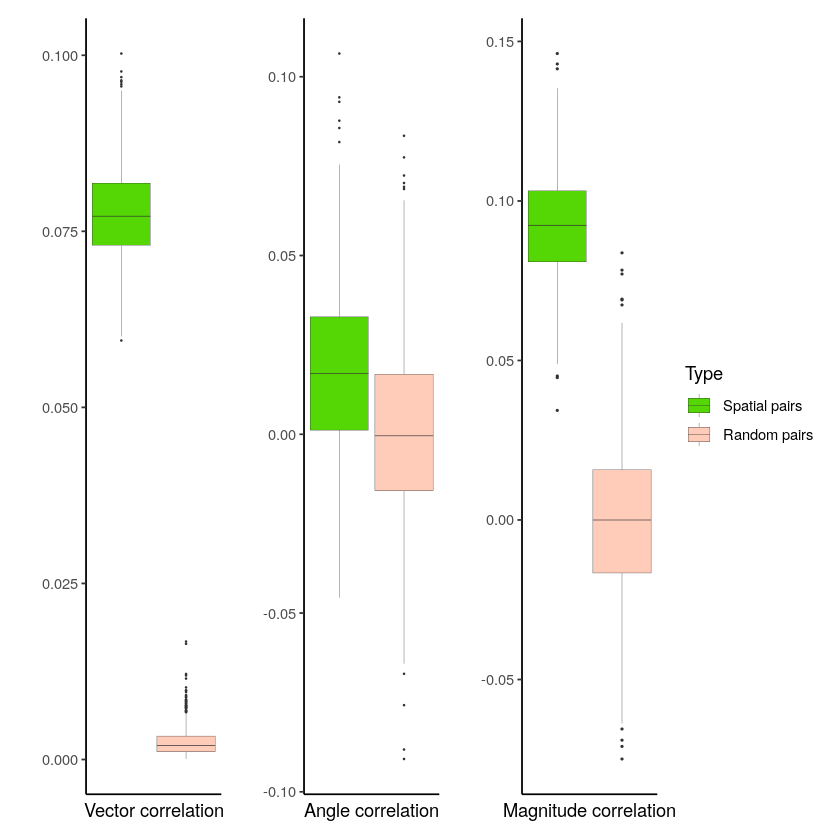

In [1434]:
vector | angle | magn

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


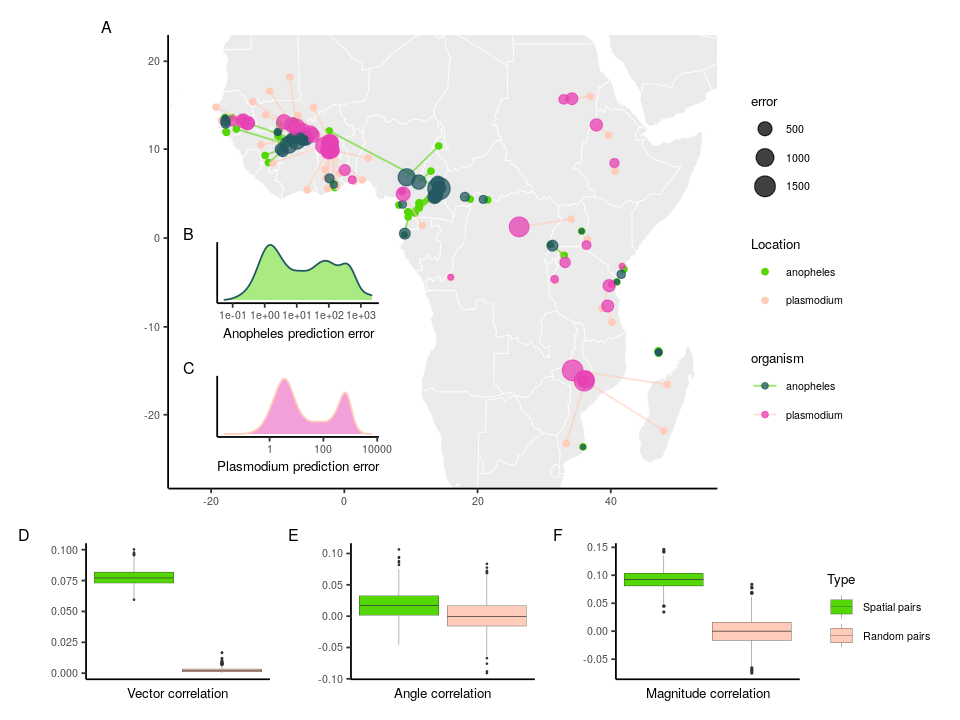

In [1442]:
errdist <- agd / pfd
mapplot <- pred_plot + inset_element(errdist,
                        left = 0.01, bottom = 0.01, right = 0.4, top = 0.6)

corrs <- vector + angle + magn + plot_layout(ncol=3)
predplt <- mapplot / corrs + plot_layout(heights=c(10, 3)) + 
            plot_annotation(tag_levels = 'A') & theme(text=element_text(size=8))
options(repr.plot.width = 8, repr.plot.height = 6)
predplt
ggsave(file.path(figdir,'empirical_anopheles_plasmodium.pdf'), width = 6.5, height = 6, units='in')

Weighted Locator runs on Anopheles and plasmodium:

In [1592]:
# error for ALL samples -

ag <- fread('data/ag1000g_weighted_centroids.txt')
md <- fread('data/ag1000g_v3_gambiae.txt')
ag <- merge(ag, md, on='sampleID')
ag <- ag[,c('x','y','kd_x','kd_y')]
ag[] <- lapply(ag, as.numeric)
ag$organism <- 'anopheles'
ag <- ag[ag$y < 25,]

pf <- fread('data/pf7_africa_weighted_centroids.txt')
md <- fread('data/pf7_africa_QC.txt')
pf <- merge(pf, md, on='sampleID')
pf <- pf[,c('x','y','kd_x','kd_y')]
pf[] <- lapply(pf, as.numeric)
pf$organism <- 'plasmodium'

pd <- rbind(ag, pf)
tlocs <- as.matrix(pd[,c('x','y')])
plocs <- as.matrix(pd[,c('kd_x','kd_y')])
pd$error <- sapply(1:nrow(plocs),function(e) spDistsN1(t(as.matrix(plocs[e,])),
                   t(as.matrix(tlocs[e,])),longlat = TRUE))

summary <- pd %>% group_by_at(c('x', 'y', 'organism')) %>%
                  summarize(kd_x_mean = mean(kd_x),
                  kd_y_mean = mean(kd_y),
                  error = mean(error))

`summarise()` has grouped output by 'x', 'y'. You can override using the `.groups` argument.


In [1593]:
# condense proximate Anopheles sampling locations in Cameroon

afgroup <- summary[summary$y < 10 & 
            summary$y > 4 &
            summary$x > 10 &
            summary$x < 15 &
            summary$organism == 'anopheles',]
summary <- summary[!(summary$y < 10 & 
            summary$y > 4 &
            summary$x > 10 &
            summary$x < 15 &
            summary$organism == 'anopheles'),]

mean <- colMeans(afgroup[,c('x','y','error','kd_x_mean','kd_y_mean')])

summary <- rbind(summary, data.table(x=mean['x'], y=mean['y'], error=mean['error'], kd_x_mean=mean['kd_x_mean'], kd_y_mean=mean['kd_y_mean'], organism='anopheles'))

afgroup <- summary[summary$y < 15 & 
            summary$y > 10 &
            summary$x > 10 &
            summary$x < 15 &
            summary$organism == 'anopheles',]
summary <- summary[!(summary$y < 15 & 
            summary$y > 10 &
            summary$x > 10 &
            summary$x < 15 &
            summary$organism == 'anopheles'),]

mean <- colMeans(afgroup[,c('x','y','error','kd_x_mean','kd_y_mean')])

summary <- rbind(summary, data.table(x=mean['x'], y=mean['y'], error=mean['error'], kd_x_mean=mean['kd_x_mean'], kd_y_mean=mean['kd_y_mean'], organism='anopheles'))

In [1594]:
pred_plot <- ggplot()+theme_classic()+
            # plot map
            coord_map(projection = "mollweide",
                   xlim=c(min(na.omit(c(summary$kd_x_mean,summary$x)))-2.5,
                          max(na.omit(c(summary$kd_x_mean,summary$x)))+2.5),
                   ylim=c(min(na.omit(c(summary$kd_y_mean,summary$y)))-2.5,
                          max(na.omit(c(summary$kd_y_mean,summary$y)))+2.5))+
            geom_polygon(data=fortify(map),aes(x=long,y=lat,group=group),fill="#ebebeb",color="white",lwd=0.2)+
                            theme(axis.title = element_blank())+
            geom_point(summary, mapping=aes(x=x, y=y, group=organism, color=organism)) +
            scale_color_manual(name="Location", values=c(aglight, pfdark)) +   
            new_scale_colour() +
            geom_segment(summary, mapping=aes(x=x, y=y, xend=kd_x_mean, yend=kd_y_mean, group=organism, color=organism), alpha=0.6) +
            scale_color_manual(values=c(aglight, pfdark)) +
            new_scale_colour() +
            geom_point(summary, mapping=aes(x=kd_x_mean, y=kd_y_mean, group=organism, color=organism, size=error), alpha=0.75) + 
            scale_color_manual(values=c(agdark, pflight))

Regions defined for each Polygons



In [1595]:
mean(pd[pd$organism=='anopheles',]$error)
median(pd[pd$organism=='anopheles',]$error)
mean(pd[pd$organism=='plasmodium',]$error)
median(pd[pd$organism=='plasmodium',]$error)

[1] 116.3111

[1] 13.16621

[1] 151.242

[1] 6.927165

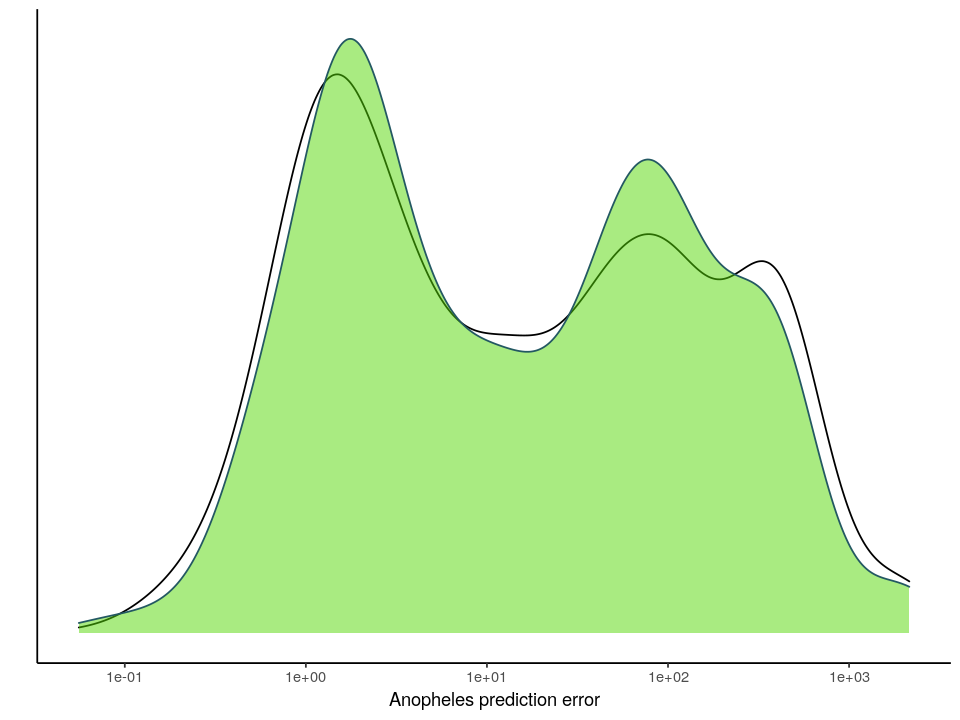

In [1570]:
agd <- ggplot(mapping = aes(pd[pd$organism=='anopheles',]$error))+theme_classic()+
        geom_density(aes(agemperr)) +
        geom_density(fill=aglight, color=agdark, alpha=0.5)+
        ylab('')+xlab('Anopheles prediction error')+
        theme(axis.ticks.y = element_blank(),
        axis.text.y = element_blank()) +scale_x_continuous(trans='log10')

agxlim <- layer_scales(agd)$x$get_limits()
agylim <- layer_scales(agd)$y$get_limits()
agd

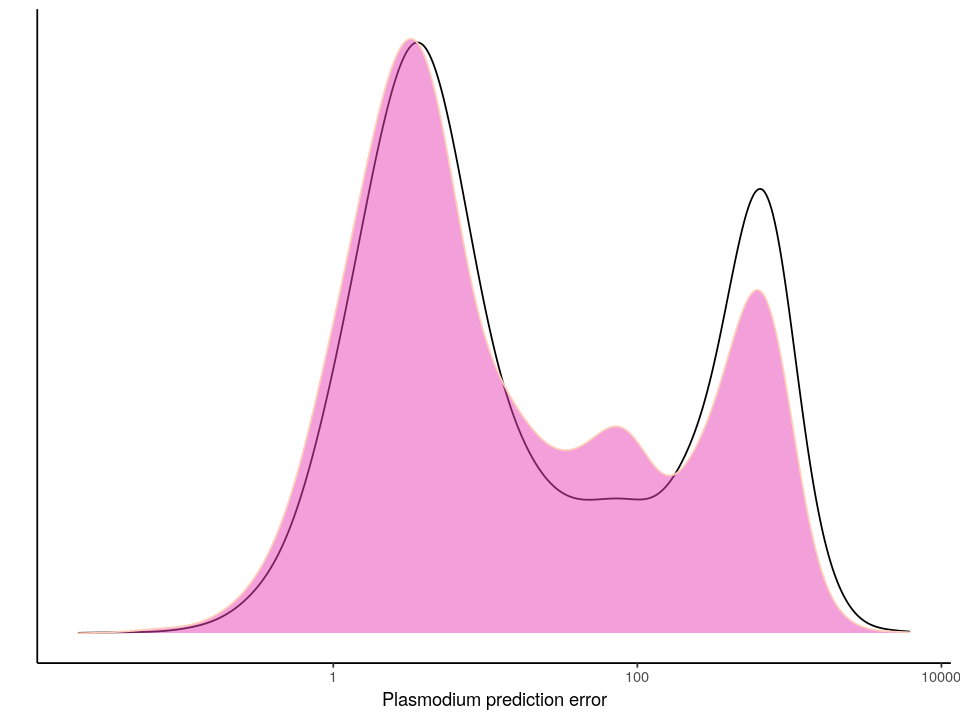

In [1571]:
pfd <- ggplot(mapping = aes(pd[pd$organism=='plasmodium',]$error))+theme_classic()+
        geom_density(aes(pfemperr)) + 
        geom_density(fill=pflight, color=pfdark, alpha=0.5)+
        ylab('')+xlab('Plasmodium prediction error')+
        theme(axis.ticks.y = element_blank(),
        axis.text.y = element_blank())+scale_x_continuous(trans='log10')
       # expand_limits(x=0, y=0)#+
        #scale_y_continuous(breaks=c(0, 5, 10, 15, 20))
pfxlim <- layer_scales(pfd)$x$get_limits()
pfylim <- layer_scales(pfd)$y$get_limits()
pfd

In [1572]:
# residual correlations

corr = fread('data/ag_pf_weighted_correlation.txt')
corr$type = rep('Spatial pairs', nrow(corr))
perm = fread('data/ag_pf_weighted_permutation.txt')
perm$type = rep('Random pairs', nrow(perm))
corr_perm = rbind(corr, perm)
corr_perm$Mag <- corr_perm$mag

In [1573]:
print(c('vector correlation:', mean(corr_perm[corr_perm$type == 'Spatial pairs',]$vector)))
print(c('angle correlation:',mean(corr_perm[corr_perm$type == 'Spatial pairs',]$angle)))
print(c('magnitude correlation:',mean(corr_perm[corr_perm$type == 'Spatial pairs',]$Mag)))

[1] "vector correlation:" "0.0357281848149086" 
[1] "angle correlation:"    "-0.000711065576523522"
[1] "magnitude correlation:" "0.0920499358410536"    


In [1574]:
vector <- ggplot()+theme_classic()+
    geom_boxplot(corr_perm, lwd=0.1, outlier.size=0.1, mapping=aes(x=vector, fill=reorder(type, -vector)), show.legend = FALSE)+coord_flip()+
    scale_fill_manual(name="Type", values=c("Spatial pairs"=aglight, "Random pairs"=pfdark))+
    ylab('Vector correlation')+xlab('')+theme(
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank())

angle <- ggplot()+theme_classic()+
    geom_boxplot(corr_perm, lwd=0.1, outlier.size=0.1, mapping=aes(x=angle, fill=reorder(type, -vector)), show.legend = FALSE)+coord_flip()+
    scale_fill_manual(name="Type", values=c("Spatial pairs"=aglight, "Random pairs"=pfdark))+
    ylab('Angle correlation')+xlab('')+theme(
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank())

magn <- ggplot()+theme_classic()+
    geom_boxplot(corr_perm, lwd=0.1, outlier.size=0.25, mapping=aes(x=Mag, fill=reorder(type, -vector)))+coord_flip()+
    scale_fill_manual(name="Type", values=c("Spatial pairs"=aglight, "Random pairs"=pfdark))+
    ylab('Magnitude correlation')+xlab('')+theme(
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank())

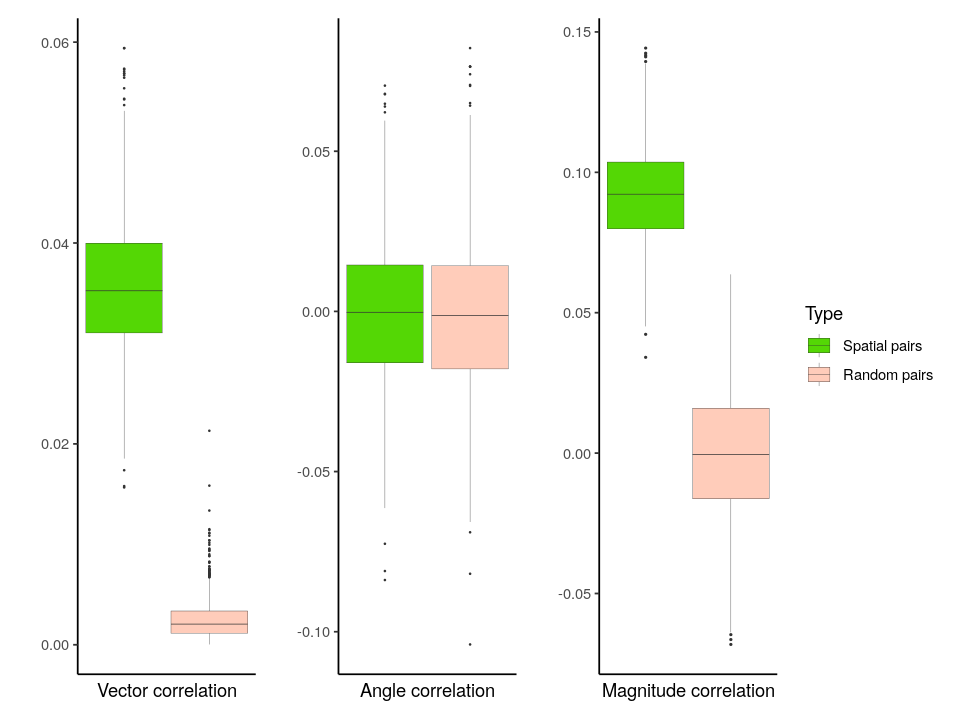

In [1575]:
vector | angle | magn

In [1586]:
mean(pd[pd$organism=='anopheles',]$error)
median(pd[pd$organism=='anopheles',]$error)
mean(pd[pd$organism=='plasmodium',]$error)
median(pd[pd$organism=='plasmodium',]$error)

[1] 116.3111

[1] 13.16621

[1] 151.242

[1] 6.927165

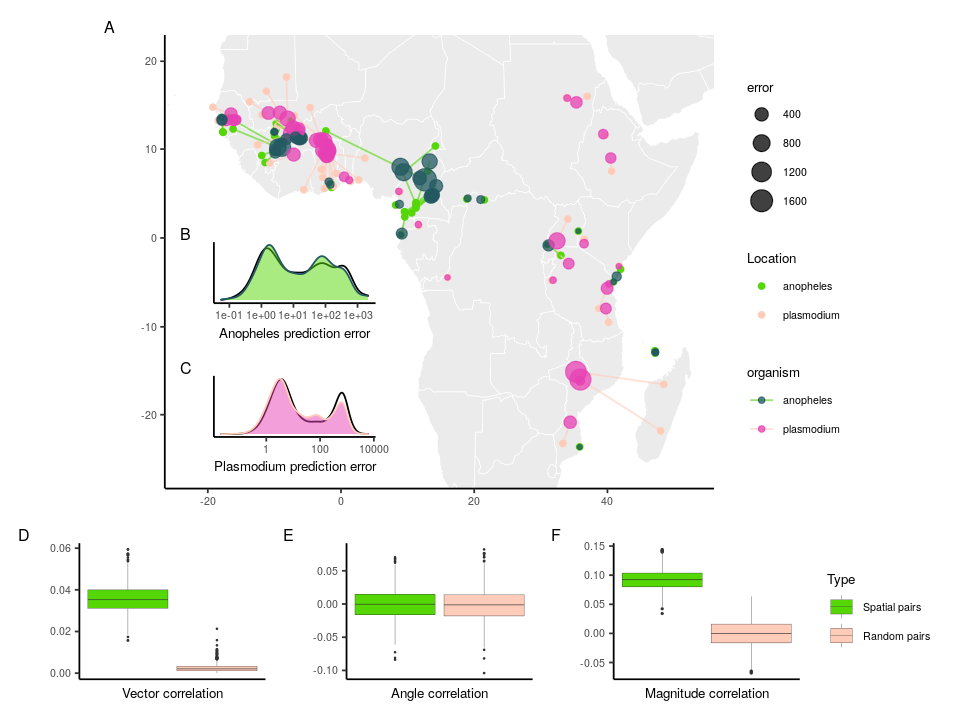

In [1576]:
errdist <- agd / pfd
mapplot <- pred_plot + inset_element(errdist,
                        left = 0.01, bottom = 0.01, right = 0.4, top = 0.6)

corrs <- vector + angle + magn + plot_layout(ncol=3)
predplt <- mapplot / corrs + plot_layout(heights=c(10, 3)) + 
            plot_annotation(tag_levels = 'A') & theme(text=element_text(size=8))
options(repr.plot.width = 8, repr.plot.height = 6)
predplt
ggsave(file.path(figdir,'weighted_anopheles_plasmodium.pdf'), width = 6.5, height = 6, units='in')

Slimulated skewed training sets

In [1577]:
df <- fread('data/all_skew_predlocs.txt')
df$skew_scale <- rescale(df$skew)
df$sigma_scale <- rescale(df$sigma)
#df$x <- rescale(df$x)
#df$y <- rescale(df$y)

In [1578]:
xfit <- glm(xerr ~ 0 + skew_scale, data=df[df$sigma==1,])
summary(xfit)


Call:
glm(formula = xerr ~ 0 + skew_scale, data = df[df$sigma == 1, 
    ])

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-16.2947   -2.1223   -0.1457    2.0151   15.4776  

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
skew_scale  0.38384    0.03111   12.34   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 9.741878)

    Null deviance: 262945  on 26840  degrees of freedom
Residual deviance: 261462  on 26839  degrees of freedom
AIC: 137271

Number of Fisher Scoring iterations: 2


In [1579]:
yfit <- glm(yerr ~ 0 + skew_scale, data=df[df$sigma==1,])
summary(yfit)


Call:
glm(formula = yerr ~ 0 + skew_scale, data = df[df$sigma == 1, 
    ])

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-15.4601   -2.0640    0.0159    2.0959   15.4381  

Coefficients:
           Estimate Std. Error t value Pr(>|t|)  
skew_scale  0.05647    0.03136     1.8   0.0718 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 9.900321)

    Null deviance: 265747  on 26840  degrees of freedom
Residual deviance: 265715  on 26839  degrees of freedom
AIC: 137704

Number of Fisher Scoring iterations: 2


In [1580]:
unweighted_sumdf <- df %>% group_by_at(c('sigma','skew','rep')) %>%
            summarize(xerr_mean = mean(xerr),
                      yerr_mean = mean(yerr),
                      err_mean = mean(err))

`summarise()` has grouped output by 'sigma', 'skew'. You can override using the `.groups` argument.


In [1581]:
unweighted_error <- mean(sumdf[sumdf$sigma == 1 & sumdf$skew == 1,]$err_mean)
unweighted_xerr <- mean(sumdf[sumdf$sigma == 1 & sumdf$skew == 1,]$xerr_mean)
unweighted_yerr <- mean(sumdf[sumdf$sigma == 1 & sumdf$skew == 1,]$yerr_mean)

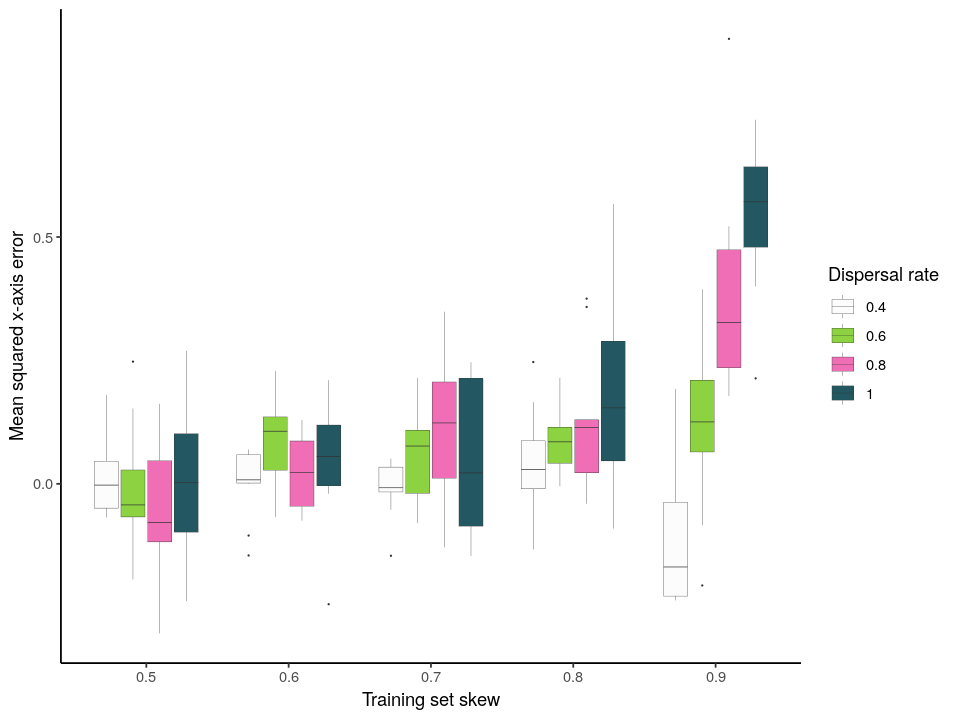

In [1582]:
ggplot()+theme_classic()+
        geom_boxplot(unweighted_sumdf,lwd=0.1, outlier.size=0.001,  mapping=aes(x=factor(skew), y=xerr_mean, fill=factor(sigma)))+
        scale_fill_manual(name="Dispersal rate", values=rev(spal))+ylab('Mean squared x-axis error')+xlab('Training set skew')

In [1583]:
# example training sets
ts5 = fread('data/sigma_1_bias_0_run_0_uniform_ts.txt')
ts6 = fread('data/sigma_1_bias_0_run_0_skew_0.6_ts.txt')
ts7 = fread('data/sigma_1_bias_0_run_0_skew_0.7_ts.txt')
ts8 = fread('data/sigma_1_bias_0_run_0_skew_0.8_ts.txt')
ts9 = fread('data/sigma_1_bias_0_run_0_skew_0.9_ts.txt')

In [1584]:
tsplot <- function(ts, titl) {
    plot = ggplot()+theme_bw()+
            labs(title=titl)+
            geom_point(ts, mapping=aes(x=x, y=y), size=0.001)+
            ylab('')+xlab('')+
            scale_x_continuous(limits=c(0, 50), breaks=c(0, 25, 50))+
            scale_y_continuous(limits=c(0, 50), breaks=c(0, 25, 50))+
            coord_fixed()
    return(plot)
    }

# skewed training sets
p5 <- tsplot(ts5, '0.5')
p6 <- tsplot(ts6, '0.6')
p7 <- tsplot(ts7, '0.7')
p8 <- tsplot(ts8, '0.8')
p9 <- tsplot(ts9, '0.9')

spal <- palgen(4)

# error
xax <- ggplot()+theme_classic()+
        geom_boxplot(unweighted_sumdf,lwd=0.1, outlier.size=0.001,  mapping=aes(x=factor(skew), y=xerr_mean, fill=factor(sigma)))+
        scale_fill_manual(name="Dispersal rate", values=rev(spal))+ylab('Mean x-axis error')+xlab('Training set skew')
yax <- ggplot()+theme_classic()+
        geom_boxplot(unweighted_sumdf, lwd=0.1, outlier.size=0.001,  mapping=aes(x=factor(skew), y=yerr_mean, fill=factor(sigma)))+
        scale_fill_manual(name="Dispersal rate", values=rev(spal))+ylab('Mean y-axis error')+xlab('Training set skew')
mgn <- ggplot()+theme_classic()+
        geom_boxplot(unweighted_sumdf, lwd=0.1, outlier.size=0.001,  mapping=aes(x=factor(skew), y=err_mean, fill=factor(sigma)))+
        scale_fill_manual(name="Dispersal rate", values=rev(spal))+ylab('Mean prediction error')+xlab('Training set skew')

Warning message:
“Removed 49 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”


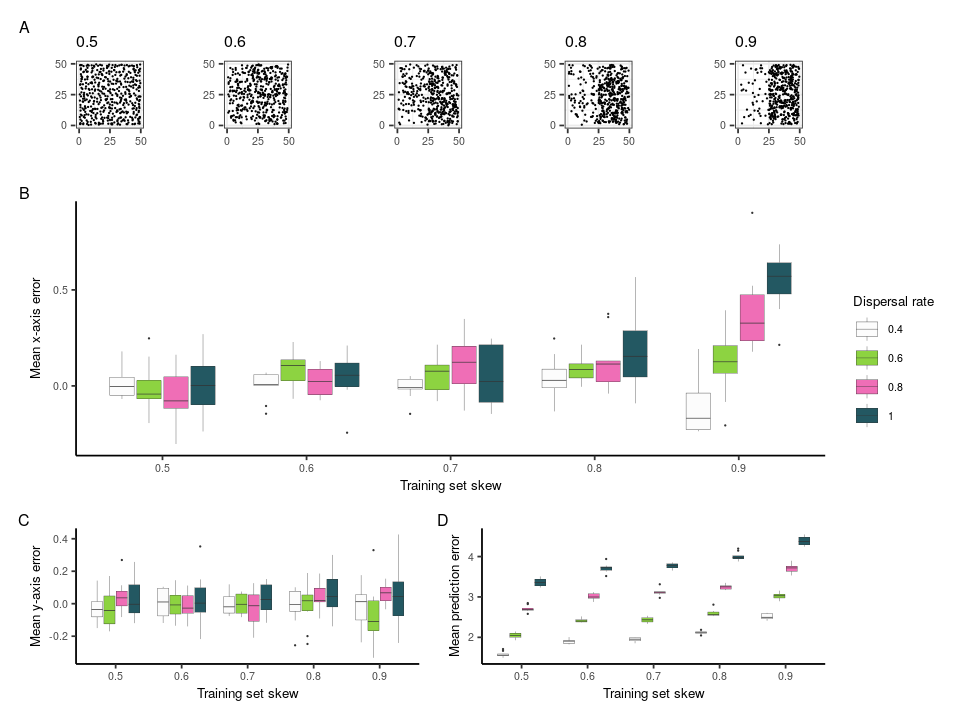

In [1585]:
ts <- p5 | p6 | p7 | p8 | p9
fig <- ts / xax / (yax | mgn) +
  plot_layout(guides = 'collect', heights=c(2, 7.5, 4)) & theme(text=element_text(size=8))
for (n in c(2, 3, 4, 5)){
    fig[[1]][[n]] <- fig[[1]][[n]]+plot_layout(tag_level = 'new')
    }
fig + plot_annotation(tag_level='A')
ggsave(file.path(figdir,'sigma_skewed_training_set.pdf'), width = 6.5, height = 6, units='in')

Predlocs with weights!

In [1547]:
df <- fread('data/weighted_all_skew_predlocs.txt')
df$skew_scaled <- rescale(df$skew, to=c(1/3, 1))
df$lm <- round(df$lm, 6)
#df$x <- rescale(df$x)
#df$y <- rescale(df$y)

In [1550]:
lmCoefficient <- function(skew_scaled, xerr) {
    if (length(skew_scaled) > 0) {
        sumres <- summary(lm(xerr ~ 0 + skew_scaled))
        return(sumres$coefficient[1])
    }
    else { return(NA) }
}
    
lmSignificance <- function(skew_scaled, xerr) {
    if (length(skew_scaled) > 0) {
        sumres <- summary(lm(xerr ~ 0 + skew_scaled))
        if (is.numeric(sumres$fstatistic[1L])) {
            return(pf(sumres$fstatistic[1L], sumres$fstatistic[2L], sumres$fstatistic[3L], lower.tail = FALSE))
        }
         else { return(NA) }
    }
    else { return(NA) }
}

In [1551]:
# linear relationships?

lmdf <- df %>% group_by_at(c('bw','lm')) %>%
         summarize(R = lmCoefficient(skew_scaled, xerr),
                   p = lmSignificance(skew_scaled, xerr))

ylmdf <- df %>% group_by_at(c('bw','lm')) %>%
         summarize(R = lmCoefficient(skew_scaled, yerr),
                   p = lmSignificance(skew_scaled, yerr))

err_df <- df %>% group_by_at(c('bw','lm','skew')) %>%
         summarize(skew = mean(skew),
                   xerr_mean = mean(xerr),
                   err_mean = mean(err),
                   yerr_mean = mean(yerr))

sum_df <- df %>% group_by_at(c('bw','lm','skew','rep')) %>%
         summarize(skew = mean(skew),
                   xerr_mean = mean(xerr),
                   err_mean = mean(err),
                   yerr_mean = mean(yerr))

`summarise()` has grouped output by 'bw'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'bw'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'bw', 'lm'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'bw', 'lm', 'skew'. You can override using the `.groups` argument.


In [1556]:
err <- ggplot(err_df[err_df$skew == 0.9,], aes(x=bw, y=lm, fill=err_mean, width=0.5, height=0.1)) + theme_classic() + 
            geom_tile() + scale_y_continuous(trans='log10') + scale_fill_viridis_c() + ylab('Lambda')+xlab('Bandwidth')+
    theme(legend.position="bottom")
xerr <- ggplot(err_df[err_df$skew == 0.9,], aes(x=bw, y=lm, fill=xerr_mean, width=0.5, height=0.1)) + theme_classic() + 
            geom_tile() + scale_y_continuous(trans='log10') + scale_fill_viridis_c()+xlab('Bandwidth')+
    theme(legend.position="bottom")
yerr <- ggplot(err_df[err_df$skew == 0.9,], aes(x=bw, y=lm, fill=yerr_mean, width=0.5, height=0.1)) + theme_classic() + 
            geom_tile() + scale_y_continuous(trans='log10') + scale_fill_viridis_c()+xlab('Bandwidth')+
    theme(legend.position="bottom")

Rval <- ggplot(lmdf, aes(x=bw, y=lm, fill=R)) + theme_classic() + geom_tile() + scale_y_continuous(trans='log10') + scale_fill_viridis_c()+ ylab('Lambda')+xlab('Bandwidth')
sig <- ggplot(lmdf, aes(x=bw, y=lm, fill=p)) + theme_classic() + geom_tile() + scale_y_continuous(trans='log10') + scale_fill_viridis_c()+ ylab('Lambda')+xlab('Bandwidth')

yRval <- ggplot(ylmdf, aes(x=bw, y=lm, fill=R)) + theme_classic() + geom_tile() + scale_y_continuous(trans='log10') + scale_fill_viridis_c()+ ylab('Lambda')+xlab('Bandwidth')
ysig <- ggplot(ylmdf, aes(x=bw, y=lm, fill=p)) + theme_classic() + geom_tile() + scale_y_continuous(trans='log10') + scale_fill_viridis_c()+ ylab('Lambda')+xlab('Bandwidth')

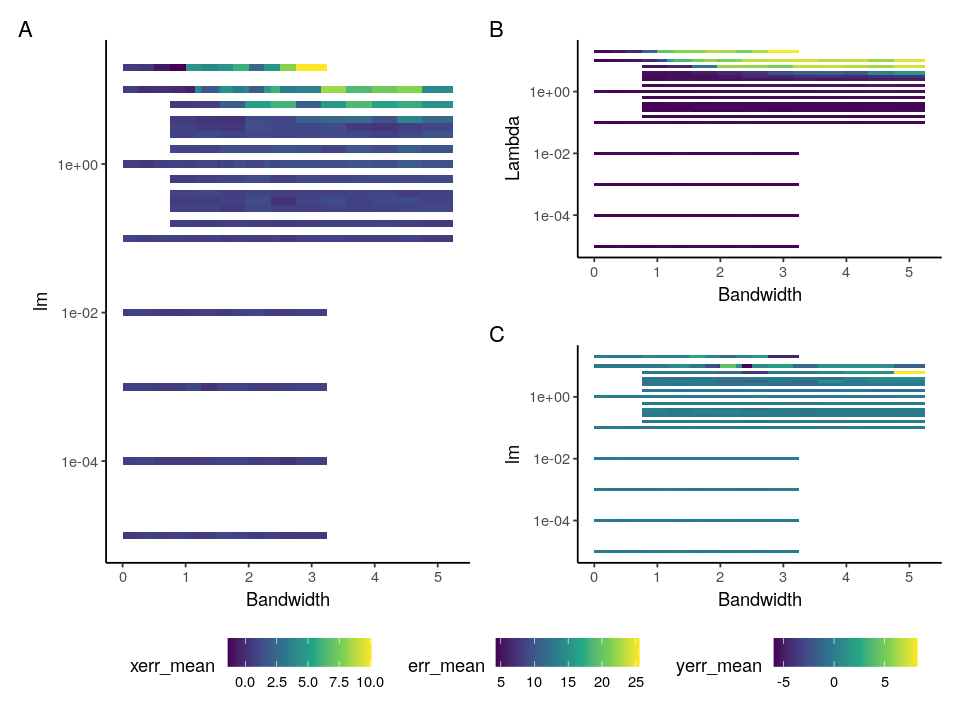

In [1557]:
(xerr + (err / yerr)) + plot_layout(guides='collect')+ plot_annotation(tag_level='A') &
  theme(legend.position='bottom')
ggsave(file.path(figdir,'weight_grid_search.pdf'), width = 6.5, height = 6, units='in')

In [1558]:
bw = 0.25
lam = 1e-5

In [1559]:
df <- merge(err_df, lmdf, on=c('bw','lm'))

In [1560]:
xdf <- df[df$skew == 0.9,]
xdf <- xdf[xdf$err_mean <= unweighted_error,]

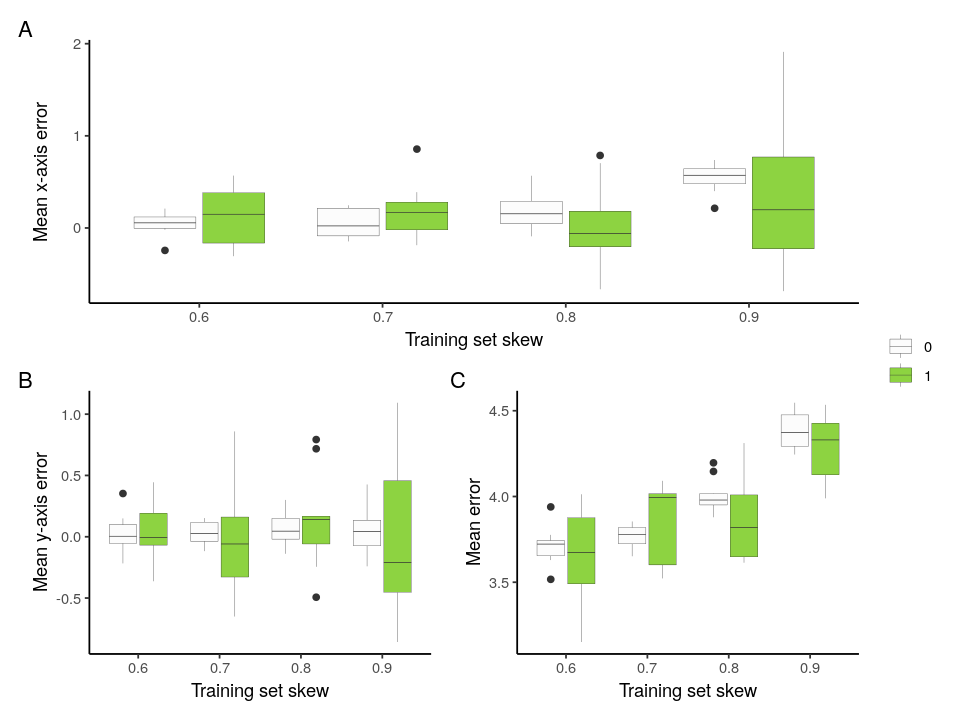

In [1565]:
rescaled_unwsumdf <- unweighted_sumdf[unweighted_sumdf$skew > 0.5 & unweighted_sumdf$sigma == 1,]
#rescaled_unwsumdf$skew <- rescale(rescaled_unwsumdf$skew)
rescaled_unwsumdf <- rescaled_unwsumdf[,c('skew','rep','xerr_mean','err_mean','yerr_mean')]
rescaled_unwsumdf$weight <- 0    
weighted_df <- sum_df[sum_df$bw == bw & sum_df$lm == lam,]
weighted_df <- weighted_df[,c('skew','rep','xerr_mean','err_mean','yerr_mean')]
weighted_df$weight <- 1
comp_df <- rbind(rescaled_unwsumdf, weighted_df)

xplot <- ggplot()+theme_classic()+
            geom_boxplot(comp_df, lwd=0.1, mapping=aes(x=factor(skew), y=xerr_mean, fill=factor(weight))) + 
            scale_fill_manual(name='', values=rev(spal))+ylab('Mean x-axis error')+xlab('Training set skew')
yplot <- ggplot()+theme_classic()+
            geom_boxplot(comp_df, lwd=0.1, mapping=aes(x=factor(skew), y=yerr_mean, fill=factor(weight))) + 
            scale_fill_manual(name='', values=rev(spal))+ylab('Mean y-axis error')+xlab('Training set skew')
eplot <- ggplot()+theme_classic()+
            geom_boxplot(comp_df, lwd=0.1, mapping=aes(x=factor(skew), y=err_mean, fill=factor(weight))) + 
            scale_fill_manual(name='', values=rev(spal))+ylab('Mean error')+xlab('Training set skew')

xR <- lmdf[lmdf$bw == bw & lmdf$lm == lam,]$R
xp<- lmdf[lmdf$bw == bw & lmdf$lm == lam,]$p

yR <- ylmdf[ylmdf$bw == bw & ylmdf$lm == lam,]$R
yp<- ylmdf[ylmdf$bw == bw & ylmdf$lm == lam,]$p


xplot / (yplot | eplot) + plot_annotation(tag_level='A') + plot_layout(guides='collect')
    #title = paste0('bandwidth ',bw,' lambda ',lam),
    #subtitle = paste('x R squared:', xR, '\n',
    #                 'x p value:', xp, '\n',
    #                 'y R squared:', yR, '\n',
    #                 'y p value:', yp))

```
bw=1.4
lam = 3.981
```
no correlation with x axis error, negative correlation with y axis error :(


```
bw=5
lam = 0.1
```
more variance in prediction error but no correlation between skew and anything

```
bw = 0.25
lam = 1e-5
```

NICE!